In [1]:
from datasets.gta5 import GTA5
from datasets.cityscapes import CityScapes
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch
from torchvision import transforms
import torchvision.transforms.functional
import matplotlib.pyplot as plt
from models.bisenet.build_bisenet import BiSeNet
from utils import poly_lr_scheduler
import pandas as pd
import numpy as np
def convert_tensor_to_image(tensor):
    image = tensor.permute(1, 2, 0)
    return image

In [2]:
gta_dataset_path='datasets/GTA5/GTA5/'
annotation_train=gta_dataset_path+'labels/'
image_train=gta_dataset_path+'images/'

cityscapes_dataset_path='datasets/Cityscapes/Cityscapes/Cityspaces/'
annotation_val=cityscapes_dataset_path+'gtFine/val'
image_val=cityscapes_dataset_path+'images/val'
resize_transform = transforms.Resize(interpolation=transforms.InterpolationMode.NEAREST_EXACT,size = (512,1024))
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
gta_train = GTA5(annotations_dir=annotation_train, images_dir=image_train)
cityscapes_val = CityScapes(annotations_dir=annotation_val, images_dir=image_val,transform=resize_transform)

train_loader = DataLoader(gta_train, batch_size=32, shuffle=False)
val_loader = DataLoader(cityscapes_val, batch_size=32, shuffle=False)

In [ ]:
#plot_loader = DataLoader(cityscapes_train, batch_size=16, shuffle=True)
(input,output)=next(iter(train_loader))
output.size()
fig, axes = plt.subplots(2, 1)
input_transpose=convert_tensor_to_image(input[0])
output_transpose=convert_tensor_to_image(output[0])
axes[0].imshow(input_transpose)
axes[1].imshow(output_transpose)
plt.show()
print(output_transpose[100][100])

In [ ]:
print(output_transpose[100][100])

In [3]:
from collections import namedtuple
Label = namedtuple('Label', 
['name','id','trainId','category',
'categoryId','hasInstances',
'ignoreInEval','color',])
labels = [
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) )]

In [4]:
for label in labels:
    print(label[1],label[2])

7 0
8 1
11 2
12 3
13 4
17 5
19 6
20 7
21 8
22 9
23 10
24 11
25 12
26 13
27 14
28 15
31 16
32 17
33 18


In [148]:
def gta2cityscapesLabels(rgb, labels):
  #arr = np.zeros(rgb.shape[:2],dtype=np.int32) ## rgb shape: (h,w,3); arr shape: (h,w)
    rgb=rgb.permute(1,2,0)
    arr_torch=torch.ones(rgb.to(device).shape[:2],dtype=torch.int8).to(device)*255
    for label in labels:
        encoding_gta=label[1]
        encoding_cityscapes=label[2]
        arr_torch[torch.all(rgb[:,:,:].to(device) == encoding_gta, axis=-1)] = encoding_cityscapes #1 = 'id'
    return arr_torch

torch.Size([1052, 1914])
torch.Size([1052, 1914, 1])


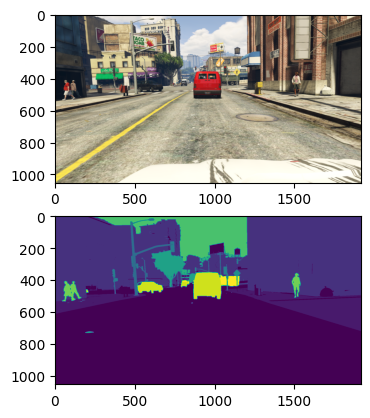

In [117]:
(input,output)=next(iter(train_loader))
output.size()
fig, axes = plt.subplots(2, 1)
input_transpose=convert_tensor_to_image(input[0])
#output_transpose=convert_tensor_to_image(output[0])
out=gta2cityscapesLabels(output[0],labels)
axes[0].imshow(input_transpose)
axes[1].imshow(out.cpu())
plt.show()


In [46]:
print(out[800][500])

tensor(0, device='cuda:0', dtype=torch.int32)


In [129]:
#save_image(out.float(),'test03.png',normalize=True)
from PIL import Image
im = Image.fromarray(out.cpu().numpy().astype(np.uint8))
im.save("your_file3.png")

In [130]:
from torchvision.utils import save_image

In [151]:
from torchvision.io import read_image 
img=read_image('datasets/GTA5/GTA5/labels/00001.png').permute(1,2,0)
img1=read_image('datasets/GTA5/GTA5/labels_correct/00001.png').permute(1,2,0)

source_path='datasets/GTA5/GTA5/labels/'
dest_path='datasets/GTA5/GTA5/labels_correct/'

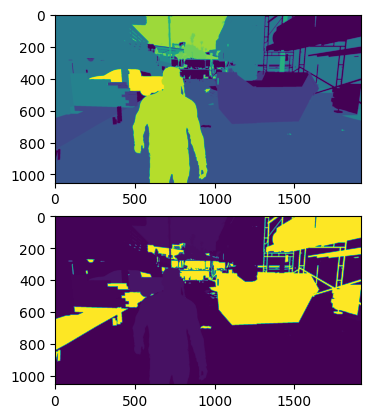

tensor([7], dtype=torch.uint8)
tensor([0], dtype=torch.uint8)


In [153]:
fig, axes = plt.subplots(2, 1)
axes[0].imshow(img)
axes[1].imshow(img1)
plt.show()
print(img[800][1500])
print(img1[800][1500])

# Convert dataset to right format

In [149]:
import os
source_path='datasets/GTA5/GTA5/labels/'
dest_path='datasets/GTA5/GTA5/labels_correct/'
for source_annotation_filename in os.listdir(source_path):
    annotation=read_image(source_path+source_annotation_filename)
    annotation_correct=gta2cityscapesLabels(annotation,labels)
    im = Image.fromarray(annotation_correct.cpu().numpy().astype(np.uint8))
    dest_annotation_path=dest_path + source_annotation_filename
    im.save(dest_annotation_path)
    print(source_annotation_filename)

02408.png
02476.png
00780.png
02412.png
00476.png
00394.png
01918.png
02473.png
01013.png
01183.png
01593.png
00333.png
01285.png
01059.png
01252.png
01180.png
01763.png
01113.png
01030.png
00369.png
01696.png
00326.png
00272.png
02365.png
02006.png
01033.png
00940.png
00435.png
01541.png
00161.png
00595.png
01339.png
00739.png
01201.png
01263.png
01566.png
00008.png
00500.png
02395.png
00430.png
01486.png
01531.png
01704.png
00348.png
02498.png
01880.png
00572.png
01377.png
01873.png
02380.png
00605.png
01922.png
01529.png
01382.png
01927.png
01092.png
01005.png
00645.png
01524.png
00491.png
01858.png
01558.png
00395.png
01829.png
02216.png
01355.png
01156.png
01094.png
02296.png
01550.png
01958.png
01971.png
01203.png
02500.png
00846.png
00238.png
00314.png
00481.png
02259.png
01154.png
00837.png
00943.png
01844.png
00725.png
01344.png
00759.png
01155.png
02203.png
02103.png
01830.png
00502.png
00263.png
01265.png
02087.png
02095.png
00832.png
01614.png
01834.png
01193.png
00856.png
